In [1]:
from sequence.components.polarization_fock.quantum_manager import _build_amp_damping_kraus_operators
import numpy as np
from math import factorial as fact
import qutip as qt
from scipy.linalg import expm
from scipy import sparse as sp


In [2]:
def single_mode_bosonic_noise_channels(noise_parameter, N):
    """This function produces the Kraus operatorsd for the single mode bosonic noise channels. This includes pure loss and 
    pure gain channels. The pure gain channel is simply the transpose of the pure loss channel.
    
    Args:
        noise_parameter (float): The noise parameter, (loss for pure loss and gain for pure gain channels). For the pure loss channel, this 
                                 parameter is the dimensionless noise term: 1-transmissivity (of beamsplitter in beamsplitter model of attenuation).
                                 For a fiber, transmissivity = e**(-chi), where chi = l/l_att, where l is the length of the fiber and 
                                 l_att is the attenuation length. If the noise_parameter is greater than 1, it is assumed to be a gain channel.
        N (int): local Hilbert space dimension being considered.
    """
    a = qt.destroy(N).full()
    a_dag = qt.create(N).full()
    n = a_dag @ a
    
    # TODO: Theoretically, verify these
    normalization = 1
    gain_channel = False

    if noise_parameter > 1: 
        gain_channel = True
        normalization = np.sqrt(1/noise_parameter)
        noise_parameter = (noise_parameter-1)/(noise_parameter) # Convert gain to loss parameter

    kraus_ops = []
    for l in range(N): # you can lose anywhere from 0 to N-1 (=trunc) photons in the truncated Hilbert space. 
        kraus_ops.append(sp.csr_array(normalization * np.sqrt(1/fact(l) * (noise_parameter/(1-noise_parameter))**l) * (np.linalg.matrix_power(a, l) @ expm(n/2 * np.log(1-noise_parameter)))))

    if gain_channel: 
        for l in range(N):
            kraus_ops[l] = kraus_ops[l].T.conjugate()

    return kraus_ops

In [3]:
N = 3
error_rate = 0.7

kraus_ops_old = _build_amp_damping_kraus_operators(error_rate, N=N)
kraus_ops_new = single_mode_bosonic_noise_channels(error_rate, N)

print("old one is:")
print(kraus_ops_old[5])
print("new one is:")
print(sp.kron(kraus_ops_new[1], kraus_ops_new[2]))

old one is:
  (0, 5)	0.5856620185738529j
  (3, 8)	0.4536518488885503j
new one is:
  (0, 5)	(0.5856620185738528+0j)
  (3, 8)	(0.4536518488885501+0j)


  (0, 0)	(0.7071067811865476+0j)
  (1, 1)	(0.35355339059327384+0j)
  (2, 2)	(0.17677669529663684+0j)
  (3, 3)	(0.08838834764831846+0j)
  (4, 4)	(0.04419417382415922+0j)
  (5, 5)	(0.0220970869120796+0j)
  (6, 6)	(0.01104854345603981+0j)
  (7, 7)	(0.0055242717280199+0j)
  (8, 8)	(0.0027621358640099497+0j)
  (9, 9)	(0.001381067932004976+0j)
  (10, 10)	(0.0006905339660024872+0j)
  (11, 11)	(0.0003452669830012439+0j)
  (12, 12)	(0.00017263349150062213+0j)
  (13, 13)	(8.631674575031119e-05+0j)
  (14, 14)	(4.3158372875155505e-05+0j)
  (15, 15)	(2.1579186437577715e-05+0j)
  (16, 16)	(1.0789593218788876e-05+0j)
  (17, 17)	(5.394796609394437e-06+0j)
  (18, 18)	(2.6973983046972275e-06+0j)
  (19, 19)	(1.3486991523486068e-06+0j)
  (20, 20)	(6.743495761743033e-07+0j)
  (21, 21)	(3.371747880871522e-07+0j)
  (22, 22)	(1.6858739404357609e-07+0j)
  (23, 23)	(8.429369702178835e-08+0j)
  (24, 24)	(4.214684851089409e-08+0j)
  :	:
  (45, 45)	(2.009718347115228e-14+0j)
  (46, 46)	(1.0048591735576158e-14+0j)


/home/asingal/home/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/asingal/home/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


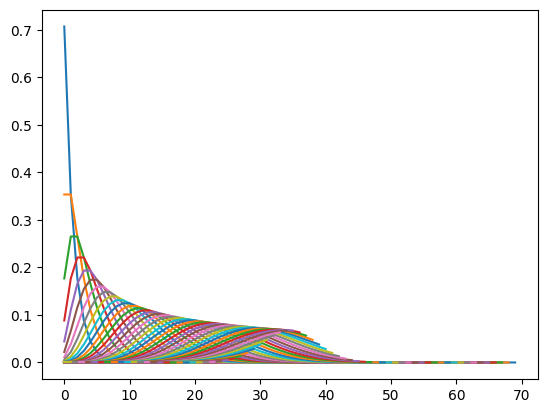

In [4]:
N = 70
gain_channel = single_mode_bosonic_noise_channels(2, N)
loss_channel = single_mode_bosonic_noise_channels(0.5, N)

for op in range(N):

    print(loss_channel[op] @ gain_channel[op])

    from matplotlib import pyplot as plt
    plt.plot((loss_channel[op] @ gain_channel[op]).data)

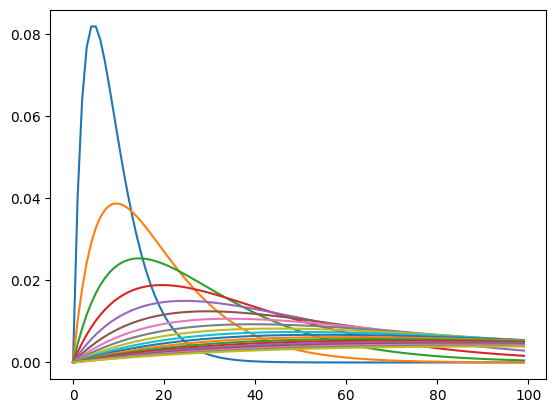

In [7]:
N = 100
plt.figure()
for G in np.arange(5.0005, N, 5):
    gain_channel = single_mode_bosonic_noise_channels(G, N)

    initial = sp.csr_array((N,N))
    initial[1,1] = 1

    dm = 0

    for op_idx in range(N):
        dm += gain_channel[op_idx] @ initial @ gain_channel[op_idx].T.conjugate()

    plt.plot([np.real(dm[i,i]) for i in range(N)])

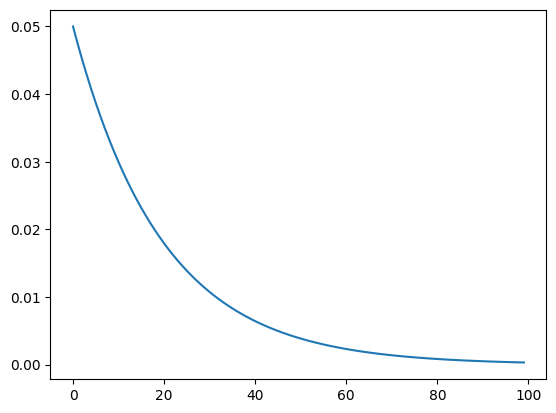

In [6]:
N = 100
plt.figure()
for G in [20]: # range(2, N, 5):
    gain_channel = single_mode_bosonic_noise_channels(G, N)

    vacuum = sp.csr_array((N,N))
    vacuum[0,0] = 1

    dm = 0

    for op_idx in range(N):
        dm += gain_channel[op_idx] @ vacuum @ gain_channel[op_idx].T.conjugate()

    plt.plot([np.real(dm[i,i]) for i in range(N)])